--- Processing WR2 ---
Found Temp Dir: .\WR2-20251125T132715Z-1-001\WR2\OCEAN_TEMPERATURE
Found MLD Dir:  .\WR2-20251125T132715Z-1-001\WR2\MIXED_LAYER_DEPTH
File Header: b'\x89HDF'
>> Detected NetCDF4/HDF5 format. Keeping 'netcdf4' (or trying 'h5netcdf').
Loading data using engine='netcdf4'...
Merging datasets...
Resampling to monthly means...
Generating Plot...


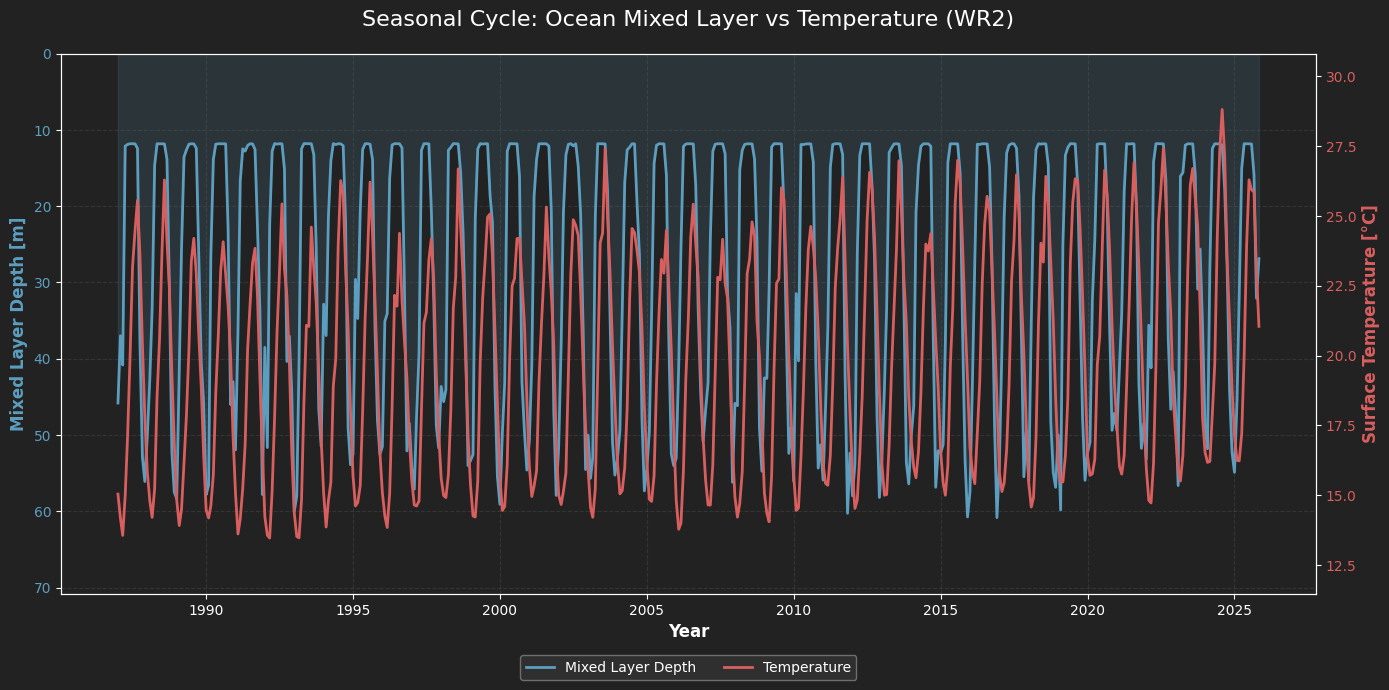

Done.


In [3]:
import xarray as xr
import matplotlib.pyplot as plt
import os
import warnings
import glob
import sys

# Suppress warnings
warnings.filterwarnings('ignore')

# --- Helper Function to Find Folders ---
def find_data_path(target_folder, subfolder):
    start_search = "."
    for root, dirs, files in os.walk(start_search):
        if target_folder in os.path.basename(root) and subfolder in dirs:
            return os.path.join(root, subfolder)
        if target_folder in dirs:
            possible_path = os.path.join(root, target_folder, subfolder)
            if os.path.exists(possible_path):
                return possible_path
    return None

# --- Main Execution for WR2 ---
region_name = "WR2"
print(f"--- Processing {region_name} ---")

# 1. Locate Folders
path_temp_dir = find_data_path(region_name, "OCEAN_TEMPERATURE")
path_mld_dir = find_data_path(region_name, "MIXED_LAYER_DEPTH")

if path_temp_dir and path_mld_dir:
    print(f"Found Temp Dir: {path_temp_dir}")
    print(f"Found MLD Dir:  {path_mld_dir}")

    path_temp_pattern = os.path.join(path_temp_dir, "*.nc")
    path_mld_pattern = os.path.join(path_mld_dir, "*.nc")

    files_temp = glob.glob(path_temp_pattern)
    files_mld = glob.glob(path_mld_pattern)

    if not files_temp:
        print("CRITICAL: No files found in Temperature folder.")
        sys.exit()

    # 2. AUTO-DETECT ENGINE & CHECK FOR CORRUPTION
    # We check the first file to see what engine we really need.
    sample_file = files_temp[0]
    detected_engine = 'netcdf4' # Default

    try:
        size = os.path.getsize(sample_file)
        if size < 2000: # If file is less than 2KB, it's likely a download error
            print(f"\nCRITICAL ERROR: File is too small ({size} bytes).")
            print(f"File: {sample_file}")
            print("This usually means the download failed (e.g., 404 HTML page).")
            print("Please delete the folder and re-download the data.")
            sys.exit()

        with open(sample_file, 'rb') as f:
            header = f.read(4)

        print(f"File Header: {header}")

        if header.startswith(b'CDF'):
            print(">> Detected NetCDF3 format. Switching engine to 'scipy'.")
            detected_engine = 'scipy'
        elif header.startswith(b'\x89HDF'):
            print(">> Detected NetCDF4/HDF5 format. Keeping 'netcdf4' (or trying 'h5netcdf').")
            detected_engine = 'netcdf4'
        elif b'html' in header.lower() or b'<!D' in header:
            print(">> Detected HTML code inside file. The file is CORRUPT.")
            sys.exit()

    except Exception as e:
        print(f"Warning: Could not sniff file header. Defaulting to netcdf4. Error: {e}")

    # 3. Load Data using Detected Engine
    print(f"Loading data using engine='{detected_engine}'...")

    try:
        ds_temp = xr.open_mfdataset(
            path_temp_pattern,
            combine='by_coords',
            chunks={"time": -1},
            engine=detected_engine
        )
        ds_mld = xr.open_mfdataset(
            path_mld_pattern,
            combine='by_coords',
            chunks={"time": -1},
            engine=detected_engine
        )
    except Exception as e:
        # Fallback for complex HDF5 errors
        print(f"Standard load failed ({e}). Trying fallback engine 'h5netcdf'...")
        ds_temp = xr.open_mfdataset(path_temp_pattern, combine='by_coords', chunks={"time": -1}, engine='h5netcdf')
        ds_mld = xr.open_mfdataset(path_mld_pattern, combine='by_coords', chunks={"time": -1}, engine='h5netcdf')

    print("Merging datasets...")
    ds_combined = xr.merge([ds_mld, ds_temp], join='inner')

    # 4. Process Monthly Means
    print("Resampling to monthly means...")
    if 'depth' in ds_combined['thetao'].coords:
        surface_temp = ds_combined['thetao'].isel(depth=0)
    else:
        surface_temp = ds_combined['thetao']

    mld = ds_combined['mlotst']

    mld_monthly = mld.resample(time='1MS').mean().load()
    temp_monthly = surface_temp.resample(time='1MS').mean().load()

    # 5. Plotting
    print("Generating Plot...")
    plt.style.use('dark_background')
    fig, ax1 = plt.subplots(figsize=(14, 7))
    fig.patch.set_facecolor('#222222')
    ax1.set_facecolor('#222222')

    # Left Axis: MLD
    color_mld = '#5c9ebf'
    ax1.set_xlabel('Year', fontsize=12, color='white', fontweight='bold')
    ax1.set_ylabel('Mixed Layer Depth [m]', color=color_mld, fontsize=12, fontweight='bold')
    ax1.fill_between(mld_monthly.time, mld_monthly, 0, color=color_mld, alpha=0.15)
    ax1.plot(mld_monthly.time, mld_monthly, color=color_mld, linewidth=2, label='Mixed Layer Depth')
    ax1.tick_params(axis='y', labelcolor=color_mld, colors='white')
    ax1.tick_params(axis='x', colors='white')
    ax1.invert_yaxis()

    # Safety for Y-limits
    max_mld_val = float(mld_monthly.max()) if mld_monthly.max().notnull() else 100
    ax1.set_ylim(max_mld_val + 10, 0)

    # Right Axis: Temperature
    ax2 = ax1.twinx()
    color_temp = '#d95f5f'
    ax2.set_ylabel('Surface Temperature [°C]', color=color_temp, fontsize=12, fontweight='bold')
    ax2.plot(temp_monthly.time, temp_monthly, color=color_temp, linewidth=2, label='Temperature')
    ax2.tick_params(axis='y', labelcolor=color_temp, colors='white')

    # Smart Limits
    min_temp = float(temp_monthly.min()) - 2 if temp_monthly.min().notnull() else 0
    max_temp = float(temp_monthly.max()) + 2 if temp_monthly.max().notnull() else 30
    ax2.set_ylim(min_temp, max_temp)

    # Title & Legend
    plt.title(f"Seasonal Cycle: Ocean Mixed Layer vs Temperature ({region_name})", fontsize=16, color='white', pad=20)
    ax1.grid(True, linestyle='--', alpha=0.2, color='gray')

    lines_1, labels_1 = ax1.get_legend_handles_labels()
    lines_2, labels_2 = ax2.get_legend_handles_labels()
    ax1.legend(lines_1 + lines_2, labels_1 + labels_2,
               loc='upper center', bbox_to_anchor=(0.5, -0.1),
               ncol=2, frameon=True, facecolor='#333333', edgecolor='gray', labelcolor='white')

    plt.tight_layout()
    plt.show()
    print("Done.")

else:
    print(f"Error: Could not find folder paths for {region_name}.")

--- Processing WR2: MLD vs Ocean Temperature ---
Found Temp Dir: .\WR2-20251125T132715Z-1-001\WR2\OCEAN_TEMPERATURE
Found MLD Dir:  .\WR2-20251125T132715Z-1-001\WR2\MIXED_LAYER_DEPTH
Loading and sanitizing files...
Concatenating...
Processing variables...

RESULTS FOR WR2:
Correlation (r): -0.503
R-squared: 0.253
Generating Time Series Plot...


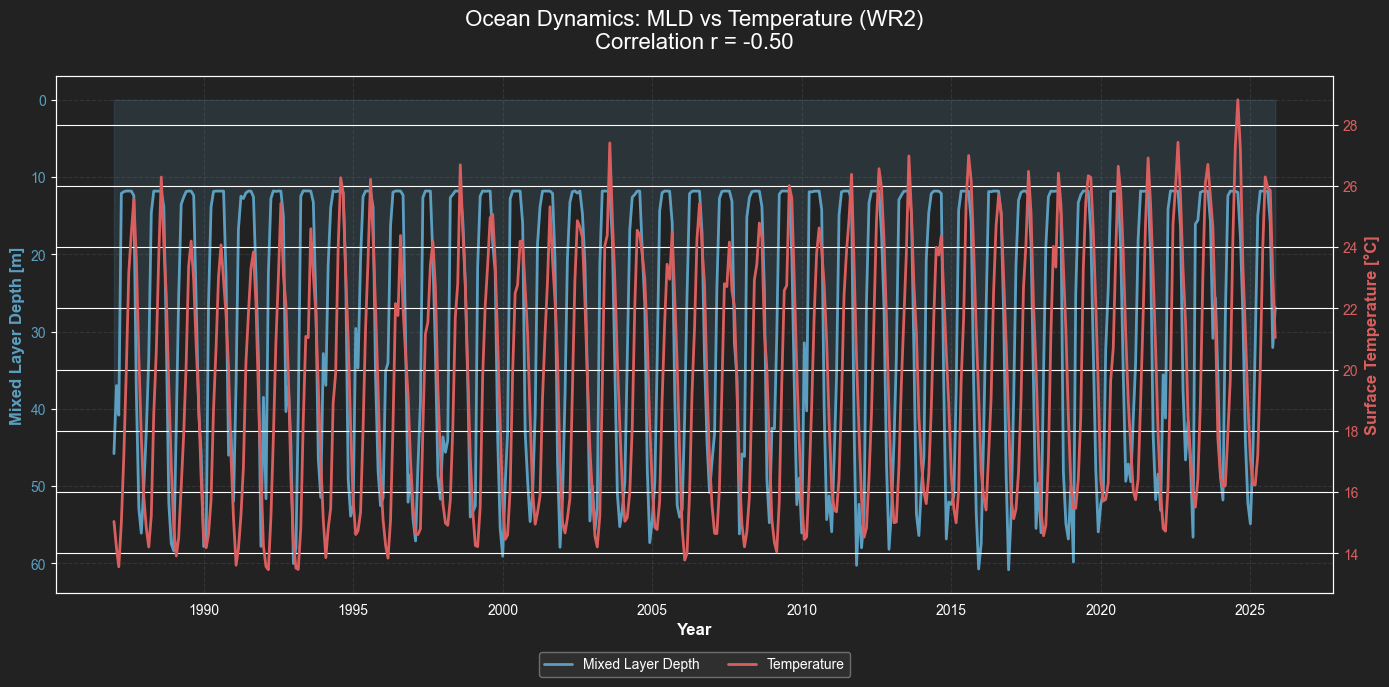

Generating Scatter Plot...


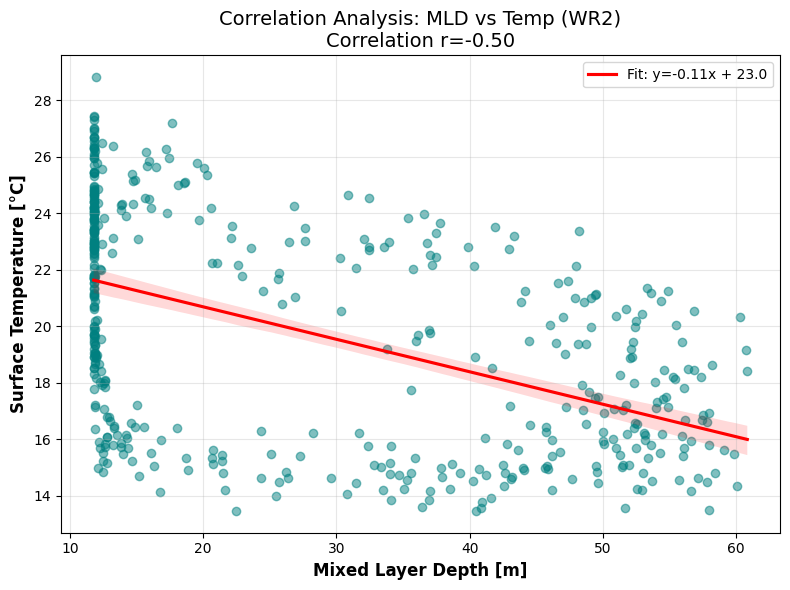

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import os
import warnings
import glob
import numpy as np
import sys

# Suppress warnings
warnings.filterwarnings('ignore')

# --- Configuration ---
region_name = "WR2"
print(f"--- Processing {region_name}: MLD vs Ocean Temperature ---")

# --- Helper 1: Find Folders ---
def find_data_path(target_folder, subfolder):
    start_search = "."
    for root, dirs, files in os.walk(start_search):
        if target_folder in os.path.basename(root) and subfolder in dirs:
            return os.path.join(root, subfolder)
        if target_folder in dirs:
             possible_path = os.path.join(root, target_folder, subfolder)
             if os.path.exists(possible_path):
                 return possible_path
    return None

# --- Helper 2: Load & Sanitize (Robust) ---
def load_and_sanitize(file_path):
    """
    Opens a NetCDF file, checks for engine issues, and rounds coordinates.
    """
    try:
        # 1. Size Check
        if os.path.getsize(file_path) < 2000:
            print(f"Skipping small/corrupt file: {os.path.basename(file_path)}")
            return None

        # 2. Open Dataset (Autodetect engine via xarray default, fallback to h5netcdf)
        try:
            ds = xr.open_dataset(file_path, chunks={"time": -1})
        except:
            try:
                ds = xr.open_dataset(file_path, chunks={"time": -1}, engine='h5netcdf')
            except:
                ds = xr.open_dataset(file_path, chunks={"time": -1}, engine='scipy')

        # 3. FIX: Round 'depth' to prevent non-monotonic errors
        if 'depth' in ds.coords:
            ds.coords['depth'] = np.round(ds.coords['depth'], 5)

        return ds
    except Exception as e:
        print(f"Error loading {os.path.basename(file_path)}: {e}")
        return None

# --- Main Execution ---

# 1. Locate Folders
path_temp_dir = find_data_path(region_name, "OCEAN_TEMPERATURE")
path_mld_dir = find_data_path(region_name, "MIXED_LAYER_DEPTH")

if path_temp_dir and path_mld_dir:
    print(f"Found Temp Dir: {path_temp_dir}")
    print(f"Found MLD Dir:  {path_mld_dir}")

    files_temp = sorted(glob.glob(os.path.join(path_temp_dir, "*.nc")))
    files_mld = sorted(glob.glob(os.path.join(path_mld_dir, "*.nc")))

    if not files_temp or not files_mld:
        print("CRITICAL: Missing .nc files in one of the folders.")
    else:
        # 2. Robust Loading Loop
        print("Loading and sanitizing files...")
        ds_temp_list = [load_and_sanitize(f) for f in files_temp]
        ds_temp_list = [ds for ds in ds_temp_list if ds is not None]

        ds_mld_list = [load_and_sanitize(f) for f in files_mld]
        ds_mld_list = [ds for ds in ds_mld_list if ds is not None]

        # 3. Concatenate
        print("Concatenating...")
        try:
            ds_temp = xr.concat(ds_temp_list, dim='time', coords='minimal', compat='override')
            ds_mld = xr.concat(ds_mld_list, dim='time', coords='minimal', compat='override')
        except Exception as e:
            print(f"Concatenation failed: {e}")
            sys.exit()

        # 4. Process Variables
        print("Processing variables...")
        # Extract Surface Temp
        if 'depth' in ds_temp['thetao'].dims:
            surface_temp = ds_temp['thetao'].isel(depth=0)
        elif 'lev' in ds_temp['thetao'].dims:
            surface_temp = ds_temp['thetao'].isel(lev=0)
        else:
            surface_temp = ds_temp['thetao']

        # Spatial Means
        if 'lat' in surface_temp.dims: surface_temp = surface_temp.mean(dim=['lat', 'lon'])

        mld = ds_mld['mlotst']
        if 'lat' in mld.dims: mld = mld.mean(dim=['lat', 'lon'])

        # Resample to Monthly
        mld_monthly = mld.resample(time='1MS').mean().compute()
        temp_monthly = surface_temp.resample(time='1MS').mean().compute()

        # Merge
        ds_combined = xr.merge([mld_monthly.rename('MLD'), temp_monthly.rename('Temp')], join='inner')
        ds_combined = ds_combined.dropna(dim='time')

        # 5. Statistical Analysis
        x = ds_combined['MLD'].values
        y = ds_combined['Temp'].values
        slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)

        print(f"\nRESULTS FOR {region_name}:")
        print(f"Correlation (r): {r_value:.3f}")
        print(f"R-squared: {r_value**2:.3f}")

        # --- PLOT 1: Dark Mode Time Series ---
        print("Generating Time Series Plot...")
        plt.style.use('dark_background')
        fig, ax1 = plt.subplots(figsize=(14, 7))
        fig.patch.set_facecolor('#222222')
        ax1.set_facecolor('#222222')

        # Left Axis: MLD
        color_mld = '#5c9ebf'
        ax1.set_xlabel('Year', fontsize=12, color='white', fontweight='bold')
        ax1.set_ylabel('Mixed Layer Depth [m]', color=color_mld, fontsize=12, fontweight='bold')
        ax1.fill_between(ds_combined.time, ds_combined['MLD'], 0, color=color_mld, alpha=0.15)
        ax1.plot(ds_combined.time, ds_combined['MLD'], color=color_mld, linewidth=2, label='Mixed Layer Depth')
        ax1.tick_params(axis='y', labelcolor=color_mld, colors='white')
        ax1.tick_params(axis='x', colors='white')
        ax1.invert_yaxis()

        # Right Axis: Temp
        ax2 = ax1.twinx()
        color_temp = '#d95f5f'
        ax2.set_ylabel('Surface Temperature [°C]', color=color_temp, fontsize=12, fontweight='bold')
        ax2.plot(ds_combined.time, ds_combined['Temp'], color=color_temp, linewidth=2, label='Temperature')
        ax2.tick_params(axis='y', labelcolor=color_temp, colors='white')

        plt.title(f"Ocean Dynamics: MLD vs Temperature ({region_name})\nCorrelation r = {r_value:.2f}", fontsize=16, color='white', pad=20)
        ax1.grid(True, linestyle='--', alpha=0.2, color='gray')

        lines_1, labels_1 = ax1.get_legend_handles_labels()
        lines_2, labels_2 = ax2.get_legend_handles_labels()
        ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=2, frameon=True, facecolor='#333333', edgecolor='gray', labelcolor='white')

        plt.tight_layout()
        plt.show()

        # --- PLOT 2: Scatter Plot ---
        print("Generating Scatter Plot...")
        plt.style.use('default')
        plt.figure(figsize=(8, 6))

        sns.regplot(x=x, y=y, scatter_kws={'alpha':0.5, 'color':'teal'}, line_kws={'color':'red', 'label':f'Fit: y={slope:.2f}x + {intercept:.1f}'})

        plt.xlabel('Mixed Layer Depth [m]', fontsize=12, fontweight='bold')
        plt.ylabel('Surface Temperature [°C]', fontsize=12, fontweight='bold')
        plt.title(f"Correlation Analysis: MLD vs Temp ({region_name})\nCorrelation r={r_value:.2f}", fontsize=14)
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()

else:
    print(f"Error: Could not find folders for {region_name}.")

--- Processing WR2: Ocean vs Atmospheric Temperature ---
Found Ocean Data: .\WR2-20251125T132715Z-1-001\WR2\OCEAN_TEMPERATURE
Found Atmos Data: .\WR2-20251125T132715Z-1-001\WR2\ATMOSPHERIC_DATA_WR2_1985_2023.csv
Loading Ocean Temperature files...
Concatenating ocean data...
Loading Atmospheric Data...
Using column '2m-air temperature' for Air Temperature.
Merging datasets...
Overlapping Data Points: 444

--- RESULTS ---
Correlation (r): 0.866
R-squared: 0.750


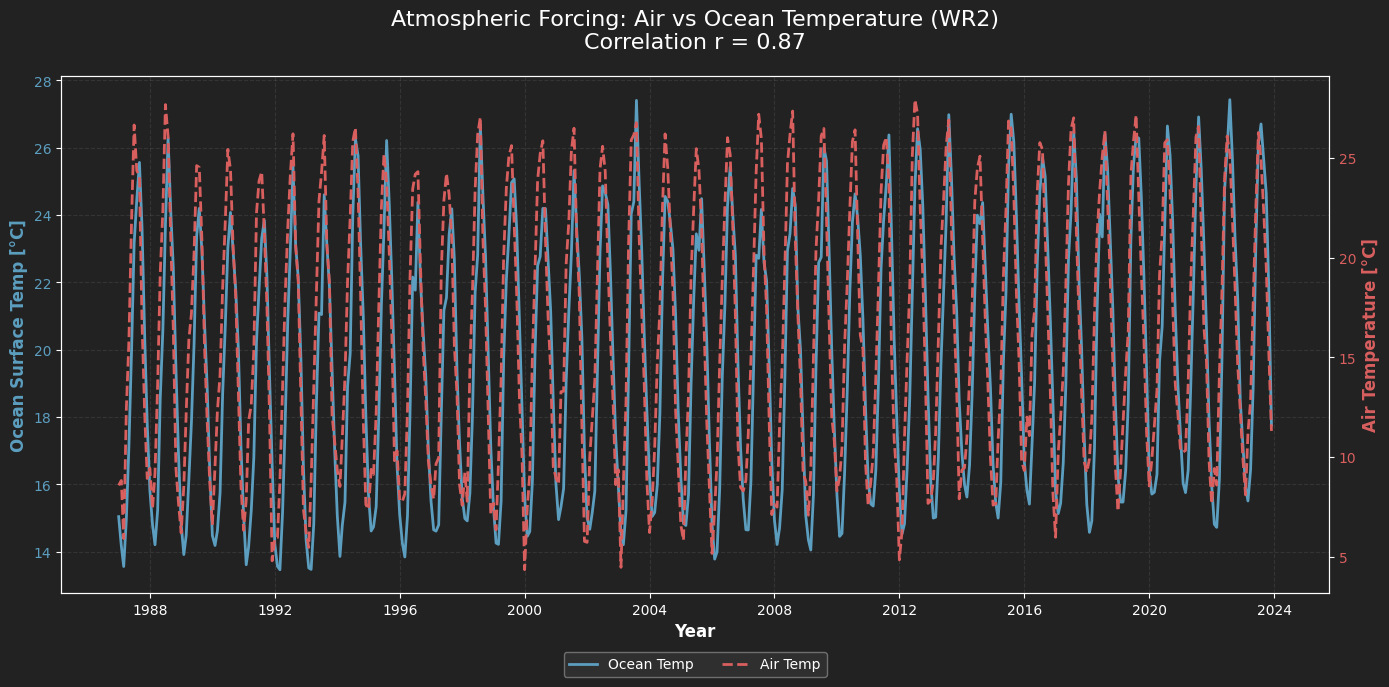

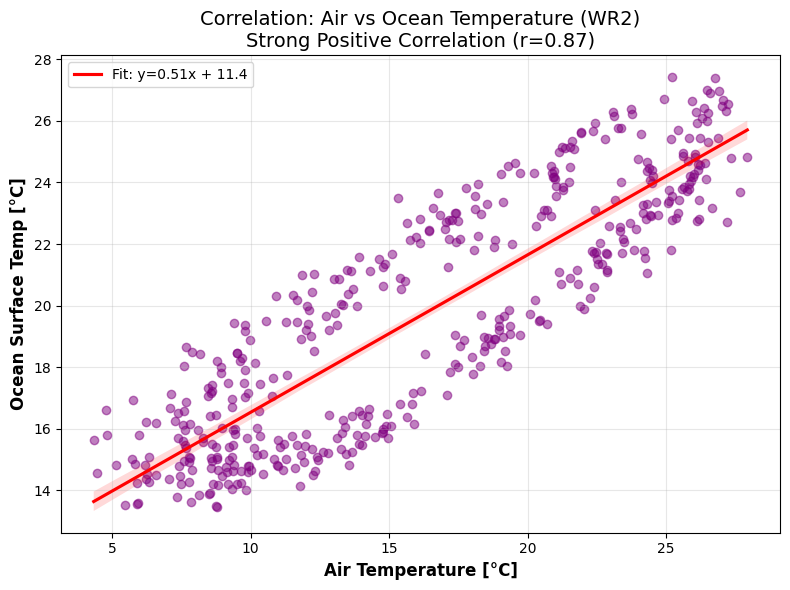

In [2]:
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import os
import warnings
import glob
import numpy as np
import sys

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# --- Configuration ---
region_name = "WR2"
atmos_filename_pattern = "ATMOSPHERIC_DATA_WR2"

print(f"--- Processing {region_name}: Ocean vs Atmospheric Temperature ---")

# --- Helper 1: Find Folders Automatically ---
def find_data_path(target_folder, subfolder_or_file):
    """
    Recursively searches for a folder or file pattern starting from the current directory.
    """
    start_search = "."
    for root, dirs, files in os.walk(start_search):
        # Case 1: subfolder inside a region folder (e.g., WR2/OCEAN_TEMPERATURE)
        if target_folder in os.path.basename(root) and subfolder_or_file in dirs:
            return os.path.join(root, subfolder_or_file)

        # Case 2: File inside a region folder
        if target_folder in os.path.basename(root):
            for file in files:
                if subfolder_or_file in file:
                    return os.path.join(root, file)

        # Case 3: Direct check if path exists
        possible_path = os.path.join(root, target_folder, subfolder_or_file)
        if os.path.exists(possible_path):
            return possible_path

        # Case 4: File in current directory
        if os.path.isfile(subfolder_or_file) and subfolder_or_file in files:
             return os.path.join(root, subfolder_or_file)

    return None

# --- Helper 2: Load & Sanitize NetCDF ---
def load_and_sanitize(file_path):
    """
    Loads a NetCDF file and fixes common coordinate errors (like non-monotonic depth).
    """
    try:
        # Check file size to avoid loading corrupt/empty downloads
        if os.path.getsize(file_path) < 2000:
            print(f"Skipping small/corrupt file: {os.path.basename(file_path)}")
            return None

        ds = xr.open_dataset(file_path, chunks={"time": -1})

        # FIX: Round the 'depth' coordinate to 5 decimals
        # This prevents "non-monotonic index" errors when merging files
        if 'depth' in ds.coords:
            ds.coords['depth'] = np.round(ds.coords['depth'], 5)

        return ds
    except Exception as e:
        print(f"Warning: Could not load {os.path.basename(file_path)}: {e}")
        return None

# --- Main Execution ---

# 1. Locate Data
path_ocean_dir = find_data_path(region_name, "OCEAN_TEMPERATURE")
path_atmos_file = find_data_path(region_name, atmos_filename_pattern)

if path_ocean_dir and path_atmos_file:
    print(f"Found Ocean Data: {path_ocean_dir}")
    print(f"Found Atmos Data: {path_atmos_file}")

    # 2. Load Ocean Temperature (Robust Method)
    print("Loading Ocean Temperature files...")
    files_temp = sorted(glob.glob(os.path.join(path_ocean_dir, "*.nc")))

    if not files_temp:
        print("CRITICAL: No .nc files found in the temperature folder.")
        sys.exit()

    # Load files individually to apply sanitization
    temp_datasets = []
    for f in files_temp:
        ds = load_and_sanitize(f)
        if ds: temp_datasets.append(ds)

    if not temp_datasets:
        print("Error: No valid datasets loaded.")
        sys.exit()

    # Concatenate files
    print("Concatenating ocean data...")
    try:
        ds_temp = xr.concat(temp_datasets, dim='time', coords='minimal', compat='override')

        # Select Surface Temperature (Depth=0)
        if 'depth' in ds_temp.dims:
            surface_temp = ds_temp['thetao'].isel(depth=0)
        elif 'lev' in ds_temp.dims:
            surface_temp = ds_temp['thetao'].isel(lev=0)
        else:
            surface_temp = ds_temp['thetao']

        # Spatial Mean (average over lat/lon if they exist)
        if 'lat' in surface_temp.dims:
            surface_temp = surface_temp.mean(dim=['lat', 'lon'])

        # Resample to Monthly Mean
        ocean_monthly = surface_temp.resample(time='1MS').mean().compute()

    except Exception as e:
        print(f"Error processing ocean data: {e}")
        sys.exit()

    # 3. Load Atmospheric Data
    print("Loading Atmospheric Data...")
    df_atmos = pd.read_csv(path_atmos_file)

    # Clean column names
    df_atmos.columns = [c.strip() for c in df_atmos.columns]

    # Parse Dates
    # Trying multiple formats to be safe
    try:
        df_atmos['time'] = pd.to_datetime(df_atmos['time'], format='%d-%m-%y %H:%M')
    except:
        df_atmos['time'] = pd.to_datetime(df_atmos['time'])

    # Find the Air Temperature column dynamically
    air_temp_col = [c for c in df_atmos.columns if 'temp' in c.lower() and 'air' in c.lower()]

    if not air_temp_col:
        print("Error: Could not find an 'Air Temperature' column in the CSV.")
        sys.exit()

    col_name = air_temp_col[0]
    print(f"Using column '{col_name}' for Air Temperature.")

    # Resample to Monthly Mean
    # Ensure we only select numeric columns to avoid errors with text columns
    atmos_monthly = df_atmos.set_index('time')[[col_name]].resample('1MS').mean()

    # Convert to Xarray for merging
    ds_atmos = xr.Dataset.from_dataframe(atmos_monthly)

    # 4. Merge and Correlate
    print("Merging datasets...")
    ds_combined = xr.merge([
        ocean_monthly.rename('Ocean_Temp'),
        ds_atmos.rename({col_name: 'Air_Temp'})
    ], join='inner')

    ds_combined = ds_combined.dropna(dim='time')
    print(f"Overlapping Data Points: {ds_combined.sizes['time']}")

    if ds_combined.sizes['time'] > 2:
        # Statistics
        x = ds_combined['Air_Temp'].values
        y = ds_combined['Ocean_Temp'].values
        slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)

        print(f"\n--- RESULTS ---")
        print(f"Correlation (r): {r_value:.3f}")
        print(f"R-squared: {r_value**2:.3f}")

        # --- PLOT 1: Time Series (Dark Mode) ---
        plt.style.use('dark_background')
        fig, ax1 = plt.subplots(figsize=(14, 7))
        fig.patch.set_facecolor('#222222')
        ax1.set_facecolor('#222222')

        # Ocean Temp (Left Axis)
        color_ocean = '#5c9ebf' # Cyan/Blue
        ax1.set_xlabel('Year', fontsize=12, color='white', fontweight='bold')
        ax1.set_ylabel('Ocean Surface Temp [°C]', color=color_ocean, fontsize=12, fontweight='bold')
        ax1.plot(ds_combined.time, ds_combined['Ocean_Temp'], color=color_ocean, linewidth=2, label='Ocean Temp')
        ax1.tick_params(axis='y', labelcolor=color_ocean, colors='white')
        ax1.tick_params(axis='x', colors='white')

        # Air Temp (Right Axis)
        ax2 = ax1.twinx()
        color_air = '#d95f5f' # Salmon/Red
        ax2.set_ylabel('Air Temperature [°C]', color=color_air, fontsize=12, fontweight='bold')
        ax2.plot(ds_combined.time, ds_combined['Air_Temp'], color=color_air, linewidth=2, linestyle='--', label='Air Temp')
        ax2.tick_params(axis='y', labelcolor=color_air, colors='white')

        plt.title(f"Atmospheric Forcing: Air vs Ocean Temperature ({region_name})\nCorrelation r = {r_value:.2f}", fontsize=16, color='white', pad=20)
        ax1.grid(True, linestyle='--', alpha=0.2, color='gray')

        # Combined Legend
        lines_1, labels_1 = ax1.get_legend_handles_labels()
        lines_2, labels_2 = ax2.get_legend_handles_labels()
        ax1.legend(lines_1 + lines_2, labels_1 + labels_2,
                   loc='upper center', bbox_to_anchor=(0.5, -0.1),
                   ncol=2, frameon=True, facecolor='#333333', edgecolor='gray', labelcolor='white')

        plt.tight_layout()
        plt.show()

        # --- PLOT 2: Scatter Plot (Scientific Style) ---
        plt.style.use('default') # Switch to white background
        plt.figure(figsize=(8, 6))
        sns.regplot(x=x, y=y, scatter_kws={'alpha':0.5, 'color':'purple'}, line_kws={'color':'red', 'label':f'Fit: y={slope:.2f}x + {intercept:.1f}'})

        plt.xlabel(f'Air Temperature [°C]', fontsize=12, fontweight='bold')
        plt.ylabel('Ocean Surface Temp [°C]', fontsize=12, fontweight='bold')
        plt.title(f"Correlation: Air vs Ocean Temperature ({region_name})\nStrong Positive Correlation (r={r_value:.2f})", fontsize=14)
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()

    else:
        print("Not enough overlapping data to create plots.")
else:
    print(f"Error: Could not find data folders or files for {region_name}.")